# Crimson Stimulation Responses

Looking through the BrainPatch stimulation responses, in particular those LFP/dendritic spikes. Need to figure out what they are...

From the "artifact_exploration" stuff I was doing, it looks like I'll mostly need to look at clips around the stim. Can probably HPF at about 70 hz and keep the interesting stuff

In [1]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
from open_ephys.analysis import Session
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.signal.windows import gaussian
import os

import re

%matplotlib ipympl

pull in the data -- we'll start with one file at a time

In [58]:
# directory = 'Z:\\BrainPatch\\20240821\\Crimson__2024-08-21_13-29-59__20mA_MinOil_2ms'
# directory = 'Z:\\BrainPatch\\20240821\\Crimson__2024-08-21_13-46-02__20mA_MinOil_2ms'
directory = 'Z:\\BrainPatch\\20240821\\Crimson__2024-08-21_13-46-01__20mA_MinOil_2ms'
session = Session(directory)
print(session)


for i_rec in range(len(session.recordnodes)):
    print(f'{len(session.recordnodes[i_rec].recordings)} recording(s) in session "{session.recordnodes[i_rec].directory}"\n')
    recordings = session.recordnodes[i_rec].recordings
    
    for i_rec,recording in enumerate(recordings):
        recording.load_continuous()
        recording.load_spikes()
        recording.load_events()
        recording.load_messages()

        print(f'Recording {i_rec} has:')
        print(f'\t{len(recording.continuous)} continuous streams')
        print(f'\t{len(recording.spikes)} spike streams')
        print(f'\t{len(recording.events)} event streams')
    
    print('\n')



Open Ephys Recording Session Object
Directory: Z:\BrainPatch\20240821\Crimson__2024-08-21_13-46-01__20mA_MinOil_2ms

<object>.recordnodes:
  Index 0: Record Node 101 (binary format)

1 recording(s) in session "Z:\BrainPatch\20240821\Crimson__2024-08-21_13-46-01__20mA_MinOil_2ms\Record Node 101"

Recording 0 has:
	1 continuous streams
	0 spike streams
	0 event streams




In [2]:
def open_sig_events(directory:str):
    # open up a session, then pull out the signal and events
    session = Session(directory)

    recording = session.recordnodes[0].recordings[0].continuous[0]

    # get out the signal
    sig = recording.samples[:,:64]

    # pull out the events -- both giving the time and the indices
    events = np.argwhere(np.diff(recording.samples[:,64]>5000) == 1)
    events = events.reshape([int(events.shape[0]/2),2])
    event_ts = events/recording.metadata['sample_rate']

    # timestamps
    timestamps = recording.sample_numbers - recording.sample_numbers[0]
    timestamps = timestamps/recording.metadata['sample_rate']

    return sig, timestamps, events, event_ts


See if we can filter out some of the respiratory noise

In [59]:
sig = session.recordnodes[0].recordings[0].continuous[0].samples[:,:64]
stim = session.recordnodes[0].recordings[0].continuous[0].samples[:,64]

sos_h = signal.butter(N = 8, Wn = [3], btype='high', output = 'sos', fs=30000)
sos_l = signal.butter(N = 8, Wn = [3000], btype='low', output = 'sos', fs=30000)
sig_hpf = signal.sosfiltfilt(sos_h, sig, axis=0)
sig_lpf = signal.sosfiltfilt(sos_l, sig, axis=0)
# fs,mag = signal.sosfreqz(sos_l, fs=30000, worN=1024)

# fig_filt, ax_filt = plt.subplots()

# ax_filt.semilogx(fs,np.abs(mag))

c:\Users\Kevin\miniconda3\envs\brainpatch\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


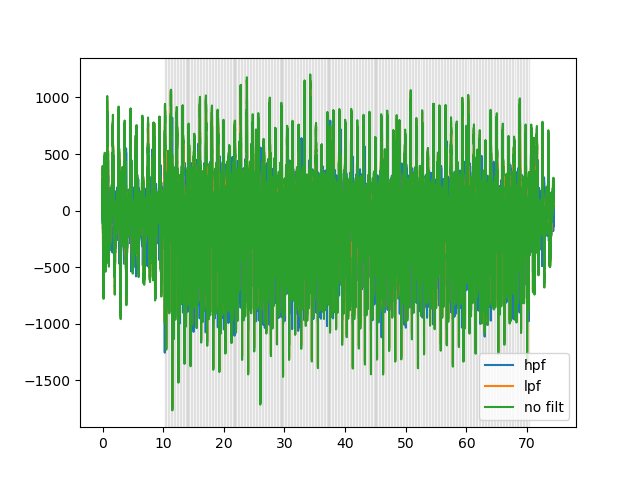

c:\Users\Kevin\miniconda3\envs\brainpatch\lib\site-packages\ipympl\backend_nbagg.py:279: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.manager.handle_json(content)


In [60]:
fig,ax = plt.subplots()

timestamps = recording.continuous[0].sample_numbers - recording.continuous[0].sample_numbers[0]
timestamps = timestamps/recording.continuous[0].metadata['sample_rate']

# ax.loglog(fs,np.abs(mag))
ax.plot(timestamps, sig_hpf[:,0])
ax.plot(timestamps, sig_lpf[:,0])
ax.plot(timestamps, sig[:,0])

ax.legend(['hpf','lpf','no filt'])

# set up the events to plot patches
events = np.argwhere(np.diff(recording.continuous[0].samples[:,64]>5000) == 1)
events = events.reshape([int(events.shape[0]/2),2])
event_ts = events/recording.continuous[0].metadata['sample_rate']

# plot the event times
for i_event,event in enumerate(event_ts):
    # print(f'{i_event}:{event}')
    ax.axvspan(event[0], event[1], color='k', alpha=.1)

In [ ]:
plt.close('all')

Grab 50 ms after each stimulation. Set the mean of the stimulation period to 0.

Find the minimum, maximum, depth of modulation, and time of each after the stimulation starts

In [ ]:
n_chans = 64 # 64 recording channels
len_ms = 150
t_len = len_ms*30 # 52 ms * 30 khz
n_events = events.shape[0] # number of stimulation events

# set up the events to plot patches
events = np.argwhere(np.diff(recording.continuous[0].samples[:,64]>5000) == 1)
events = events.reshape([int(events.shape[0]/2),2])
event_ts = events/recording.continuous[0].metadata['sample_rate']

responses = np.zeros((n_events, t_len, n_chans))
maxs = np.zeros((n_events, n_chans))
rel_maxs = np.zeros((n_events, n_chans))
abs_maxs = np.zeros((n_events, n_chans))
mins = np.zeros((n_events, n_chans))
rel_mins = np.zeros((n_events, n_chans))
abs_mins = np.zeros((n_events, n_chans))

for i_event, event in enumerate(events):
    response = sig[event[0]:event[0]+len_ms*30,:]
    means = np.mean(sig[event[0]+4:event[1]-4,:], axis = 0)
    responses[i_event,:,:] = response - means # response for each channel
    
    mins[i_event,:] = np.min(response - means, axis=0)
    rel_mins[i_event,:] = np.argmin(response - means, axis=0)/30000
    abs_mins[i_event,:] = rel_mins[i_event,:] + event_ts[i_event,0]

    # maxs[i_event,:] = np.max(response[int(rel_mins*30000),:] - means, axis=0) # only interested in stuff after the negative deviation
    # rel_maxs[i_event,:] = np.argmax(response[int(rel_mins*30000),:] - means, axis=0)/30000
    # abs_maxs[i_event,:] = rel_maxs[i_event,:] + event_ts[i_event,0]


a function version so that we can call it when rummaging through all of the directories


In [3]:
def find_responses(sig, events, len_ms:int = 25, n_chans:int = 64, sample_rate:int = 30000):

    t_len = len_ms*30 # 52 ms * 30 khz

    # set up the events to plot patches
    n_events = events.shape[0] # number of stimulation events

    responses = np.zeros((n_events, t_len, n_chans))
    # maxs = np.zeros((n_events, n_chans)) # not getting much info from these
    # rel_maxs = np.zeros((n_events, n_chans))
    # abs_maxs = np.zeros((n_events, n_chans))
    mins = np.zeros((n_events, n_chans))
    rel_mins = np.zeros((n_events, n_chans))
    abs_mins = np.zeros((n_events, n_chans))

    for i_event, event in enumerate(events):
        response = sig[event[0]:event[0]+len_ms*30,:]
        means = np.mean(sig[event[0]+4:event[1]-4,:], axis = 0)
        responses[i_event,:,:] = response - means # response for each channel
    
        mins[i_event,:] = np.min(response - means, axis=0)
        rel_mins[i_event,:] = np.argmin(response - means, axis=0)/30000
        abs_mins[i_event,:] = rel_mins[i_event,:] + event_ts[i_event,0]

    return mins, rel_mins, abs_mins

In [82]:
def plot_avg_response(signal, events, len_ms:int = 25, channel = 0, ax:plt.axes=None):
    # Plot the average response for a particular channel
    if ax is None:
        fig,ax = plt.subplots()
    

    # set up the events to plot patches
    n_events = events.shape[0] # number of stimulation events

    # put together a NxT array
    t_len = len_ms * 30
    responses = np.zeros((n_events, t_len))
    
    # go through each event
    for i_event, event in enumerate(events):
        response = signal[event[0]:event[0]+len_ms*30,channel]
        means = np.mean(signal[event[0]+4:event[1]-4]) # center the during-stimulation to 0
        responses[i_event,:] = response - means

    ax.plot(np.arange(t_len)/30, np.mean(responses, axis=0))

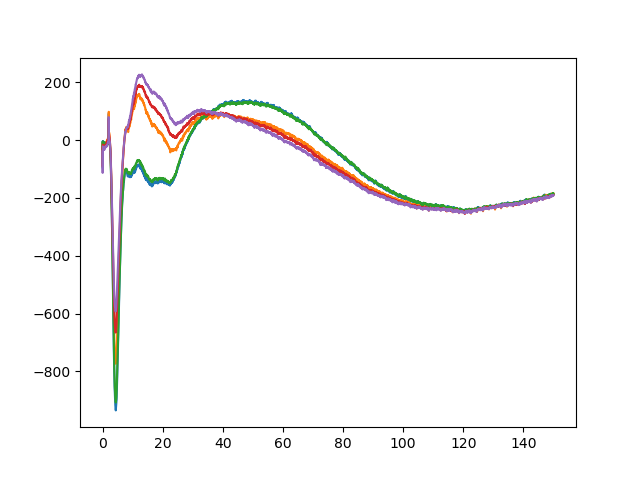

In [86]:
directory = 'Z:\\BrainPatch\\20240821\\Crimson__2024-08-21_13-46-01__20mA_MinOil_2ms'
session = Session(directory)

signal = session.recordnodes[0].recordings[0].continuous[0].samples[:,:64]
# set up the events to plot patches
events = np.argwhere(np.diff(recording.continuous[0].samples[:,64]>5000) == 1)
events = events.reshape([int(events.shape[0]/2),2])
event_ts = events/recording.continuous[0].metadata['sample_rate']

fig_avg, ax_avg = plt.subplots()

for channel in [0,5,10,15,20]:
    plot_avg_response(signal, events, len_ms= 150, channel=channel, ax=ax_avg)

ax_avg.

In [ ]:
plt_chans = [30, 31, 32, 33]
n_plt = len(plt_chans)

fig_comb,ax_comb = plt.subplots(nrows=n_plt, sharex=True, sharey = True)

# put together the timestamps
timestamps = recording.continuous[0].sample_numbers - recording.continuous[0].sample_numbers[0]
timestamps = timestamps/recording.continuous[0].metadata['sample_rate']

for i_chan, chan in enumerate(plt_chans):
    ax_comb[i_chan].plot(timestamps, sig_filt[:,i_chan])

    # plot the event times and max and min points
    for i_event,event in enumerate(event_ts):
        # print(f'{i_event}:{event}')
        ax_comb[i_chan].axvspan(event[0], event[1], color='k', alpha=.1)
        ax_comb[i_chan].scatter(abs_maxs[i_event, i_chan], maxs[i_event, i_chan], 2, color='r')
        ax_comb[i_chan].scatter(abs_mins[i_event, i_chan], mins[i_event, i_chan], 2, color='cyan')





In [61]:
# lets go through recordings in groups of locations
base_dir = 'Z:\\BrainPatch\\20240821'

dir_400 = ['Crimson__2024-08-21_13-44-07__10mA_MinOil_2ms','Crimson__2024-08-21_13-46-01__20mA_MinOil_2ms','Crimson__2024-08-21_13-47-40__15mA_MinOil_2ms','Crimson__2024-08-21_13-49-43__10mA_MinOil_2ms','Crimson__2024-08-21_13-51-50__5mA_MinOil_2ms']
dir_700 = ['Crimson__2024-08-21_13-56-49__5mA_MinOil_2ms','Crimson__2024-08-21_13-58-50__10mA_MinOil_2ms','Crimson__2024-08-21_14-00-53__15mA_MinOil_2ms','Crimson__2024-08-21_14-02-54__20mA_MinOil_2ms']
dir_1000 = ['Crimson__2024-08-21_14-05-52__5mA_MinOil_2ms','Crimson__2024-08-21_14-07-41__10mA_MinOil_2ms','Crimson__2024-08-21_14-09-46__15mA_MinOil_2ms','Crimson__2024-08-21_14-11-45__20mA_MinOil_2ms']
dir_1300 = ['Crimson__2024-08-21_14-14-26__5mA_MinOil_2ms','Crimson__2024-08-21_14-16-02__10mA_MinOil_2ms','Crimson__2024-08-21_14-17-58__15mA_MinOil_2ms','Crimson__2024-08-21_14-20-21__20mA_MinOil_2ms']
dir_1600 = ['Crimson__2024-08-21_14-23-13__5mA_MinOil_2ms','Crimson__2024-08-21_14-25-16__10mA_MinOil_2ms','Crimson__2024-08-21_14-27-12__15mA_MinOil_2ms','Crimson__2024-08-21_14-29-03__20mA_MinOil_2ms']

# dictionary of direct groups
dir_dict = {400: dir_400, 700:dir_700, 1000:dir_1000, 1300:dir_1300, 1600:dir_1600}


Pandas dataframe to keep track of all of the max vals etc

In [72]:
resp_df = pd.DataFrame(columns=['Channel_no','Current','Distance','uMin','uMin_ts','medMin','medMin_ts'])

for dist,dir_list in dir_dict.items():
    for sub_dir in dir_list:
        directory = os.path.join(base_dir, sub_dir)

        # open the directory
        sig, timestamps, events, event_ts = open_sig_events(directory)

        # pull out the stim responses
        mins, rel_mins, abs_mins = find_responses(sig, events)

        # means and medians for each channel
        uMins = np.mean(mins, axis=0)
        uMins_ts = np.mean(rel_mins, axis=0)
        medMins = np.median(mins, axis=0)
        medMins_ts = np.median(rel_mins, axis=0)

        # a nested dictionary of all of the channels responses
        tdict = {ii:{'Channel_no':ii, 
                'Current':re.search('([0-9]+)mA', sub_dir)[1],
                'Distance': dist,
                'uMin':uMins[ii],
                'uMin_ts':uMins_ts[ii],
                'medMin':medMins[ii],
                'medMin_ts':medMins_ts[ii],
                } for ii in range(64)}

        t_df = pd.DataFrame.from_dict(tdict, orient='index') # create a dataframe

        resp_df = pd.concat([resp_df, t_df], ignore_index=True)

resp_df.Current = resp_df.Current.astype(int)

C:\Users\Kevin\AppData\Local\Temp\ipykernel_4472\764849248.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resp_df = pd.concat([resp_df, t_df], ignore_index=True)


Text(0.5, 0.98, 'Response mean minimum as a function of distance (per current level)')

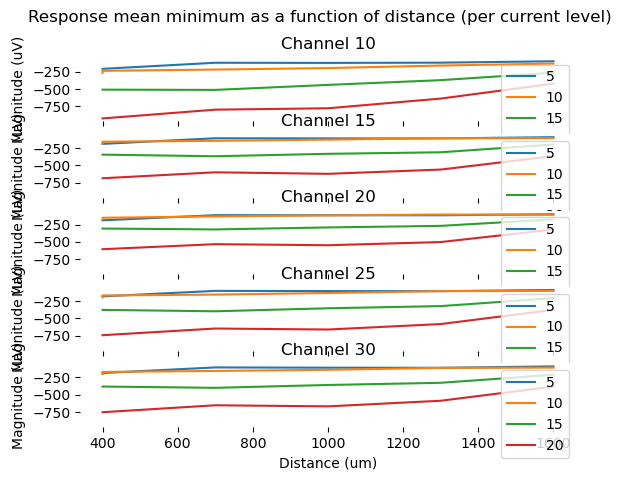

In [76]:
currents = resp_df.Current.unique()
currents.sort()
channels = [10, 15, 20, 25, 30]

fig_dist,ax_dist = plt.subplots(nrows=len(channels), sharex=True, sharey=True)
for i_chan,chan in enumerate(channels):
    for i_curr,curr in enumerate(currents):
        dist_cmp = resp_df.loc[(resp_df.Current==curr) * (resp_df.Channel_no==chan)]
        # if curr == '20':
        #     print(dist_cmp)
        ax_dist[i_chan].plot(dist_cmp.Distance, dist_cmp.uMin)

    ax_dist[i_chan].legend(currents)
    ax_dist[i_chan].set_title(f'Channel {chan}')
    ax_dist[i_chan].set_ylabel('Magnitude (uV)')

    # remove the outer boxes
    for spine in ['top','bottom','right','left']:
        ax_dist[i_chan].spines[spine].set_visible(False)
    

ax_dist[-1].set_xlabel('Distance (um)')
fig_dist.suptitle('Response mean minimum as a function of distance (per current level)')



In [68]:
resp_df.loc[((resp_df.Channel_no == 15)*(resp_df.Current == '20'))]

,Channel_no,Current,Distance,uMin,uMin_ts,medMin,medMin_ts
79,15,20,400,-683.264542,0.004417,-685.754717,0.004333
527,15,20,700,-597.583774,0.004356,-600.423077,0.004367
783,15,20,1000,-619.554964,0.004582,-608.980769,0.004433
1039,15,20,1300,-558.348126,0.004390,-563.057692,0.004367
1295,15,20,1600,-365.613651,0.004715,-364.519231,0.004733


In [69]:
resp_df.Current = resp_df.Current.astype(int)
# current = resp_df.Current.unique()

In [71]:
resp_df.Current.dtype

dtype('int32')